<a href="https://colab.research.google.com/github/parasgodhani01/SmartWaste_Classification/blob/main/Waste_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Dataset from huggingface**

In [5]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.5 MB/s eta 0:00:00


### **Dataset 1 : trashnet_enhanced** (19.9k)

In [ ]:
# from datasets import load_dataset

# data1 = load_dataset("edwinpalegre/trashnet_enhanced")

### **Dataset 2 : small trashnet** ( 2.53k)

In [ ]:
# from datasets import load_dataset
# data2 = load_dataset("kuchidareo/small_trashnet")

### **Datset 3 : trashnet** (5.5k)

In [ ]:
# data3 = load_dataset("garythung/trashnet")

## **Importing Libraries**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from collections import Counter

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## **Analysis of Data**

### **Dataset : small_trashnet**

In [6]:
from datasets import load_dataset
dataset = load_dataset("kuchidareo/small_trashnet", split='train')

README.md:   0%|          | 0.00/4.84k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/43.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2527 [00:00<?, ? examples/s]

In [ ]:
print("--------------------------")
print("Small Trashnet Datset")
print("--------------------------\n")

# Set to store unique image dimensions for the entire dataset
all_dimensions_set = set()

# Dictionary to count images per label
label_image_count = {}

# Iterate over the dataset to process images
total_images = 0  # Variable to count total images in the dataset

for item in dataset:
    label = item['label']
    image = item['image']

    # Update count for the label
    if label not in label_image_count:
        label_image_count[label] = 0
    label_image_count[label] += 1
    total_images += 1

    # Check image dimensions
    width, height = image.size
    channels = len(image.getbands())
    all_dimensions_set.add((width, height, channels))


# Display the count of images for each label
for label, count in label_image_count.items():
    print(f"{label} folder contains {count} images.")

# Display the total number of images in the dataset
print(f"\nTotal images in the dataset: {total_images}")

# Determine if all images in the entire dataset have the same dimensions
if len(all_dimensions_set) == 1:
    width, height, channels = all_dimensions_set.pop()
    print(f"All images in the dataset have the same dimensions: {width}x{height} with {channels} color channels.")
else:
    print("The images in the dataset have different dimensions or color channels.")

--------------------------
Small Trashnet Datset
--------------------------

0 folder contains 403 images.
1 folder contains 501 images.
2 folder contains 410 images.
3 folder contains 594 images.
4 folder contains 482 images.
5 folder contains 137 images.

Total images in the dataset: 2527
All images in the dataset have the same dimensions: 512x384 with 3 color channels.


### **Images of Each Category**

In [7]:
# Define the label mapping
label_mapping = {
    0: 'cardboard',
    1: 'glass',
    2: 'metal',
    3: 'paper',
    4: 'plastic',
    5: 'trash'
}

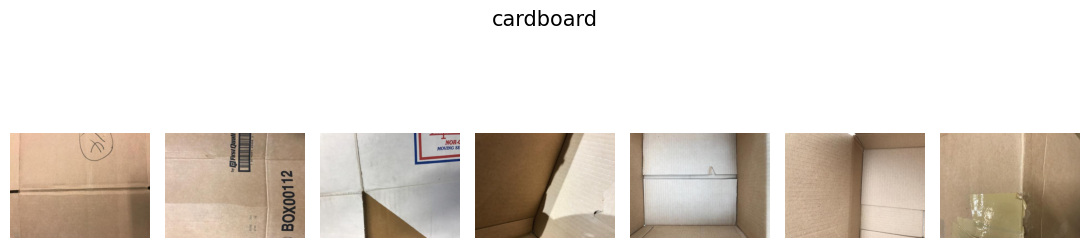

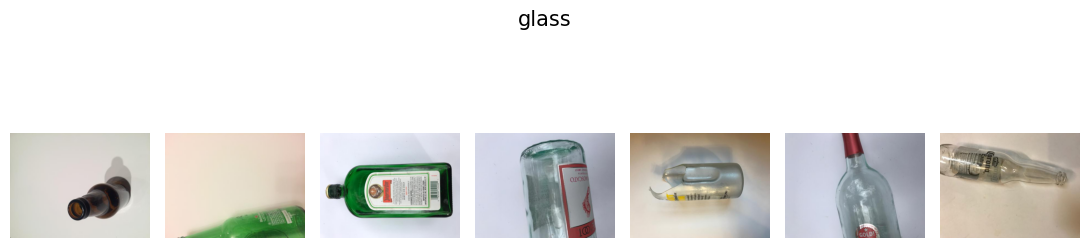

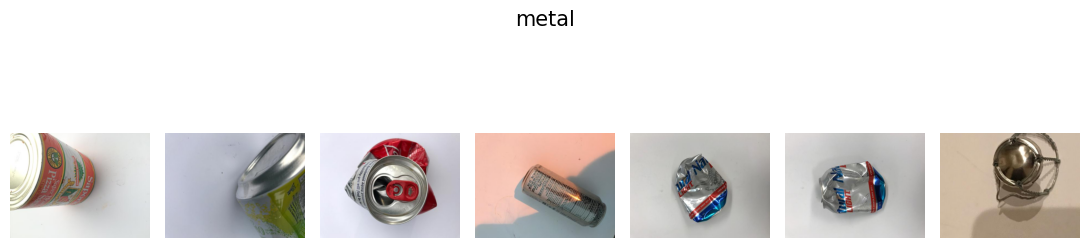

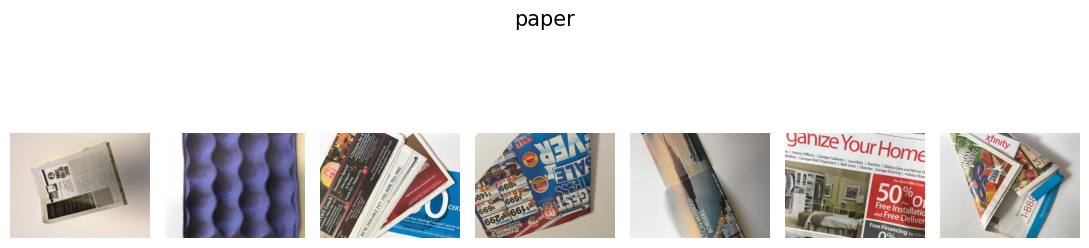

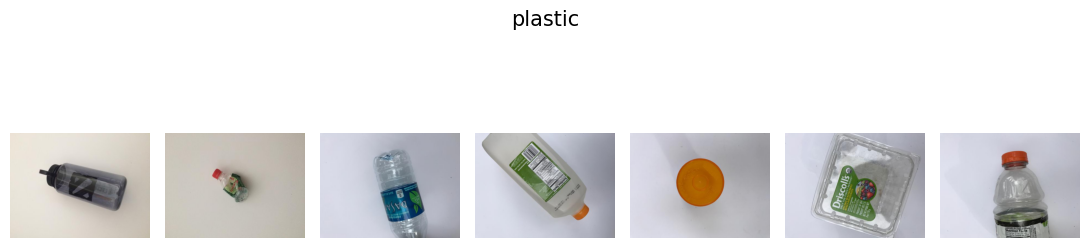

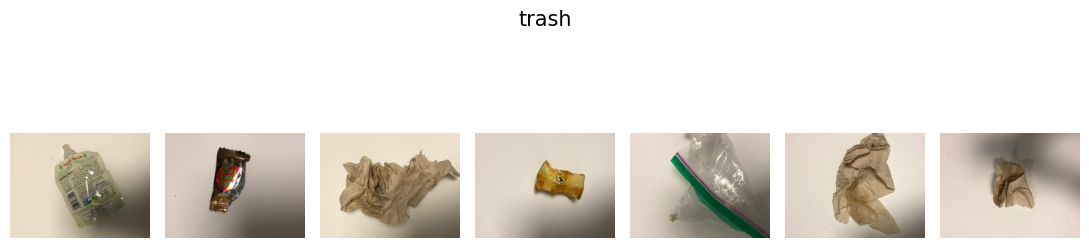

In [9]:
# Get unique garbage types (labels) from the dataset
garbage_types = sorted(set([item['label'] for item in dataset]))

# Set up the display for each category
for garbage_type in garbage_types:
    # Filter the dataset to include only the current garbage type
    filtered_dataset = [item for item in dataset if item['label'] == garbage_type]

    # Select the first 7 images for display
    images = []
    for i, item in enumerate(filtered_dataset):
        if i >= 7:
            break
        images.append(item['image'])

    # Skip this category if it has no images
    if not images:
        continue

    # Create a figure and subplots
    fig, axs = plt.subplots(1, len(images), figsize=(11, 3))

    # Display each image
    for i, img in enumerate(images):
        axs[i].imshow(img)
        axs[i].axis('off')

    # Set the title using only the name
    fig.suptitle(f"{label_mapping[garbage_type]}", fontsize=15, y=1.03)
    plt.tight_layout()
    plt.show()

In [10]:
# Extract class labels
# Iterate directly through the dataset, which is already the 'train' split
labels = [label_mapping[example['label']] for example in dataset]

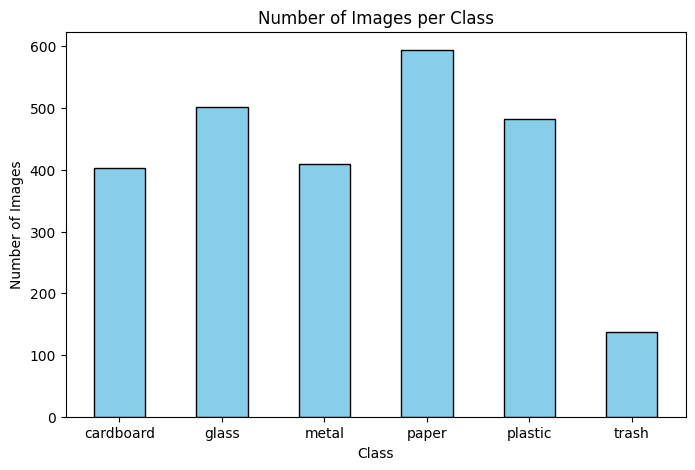

In [11]:
# Count images per class
class_counts = Counter(labels)

# Plot bar chart
plt.figure(figsize=(8,5))
plt.bar(class_counts.keys(),
        class_counts.values(),
        color='skyblue',
        edgecolor='k',
        width=0.5)

plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Number of Images per Class")
plt.xticks(rotation=0)
plt.show()

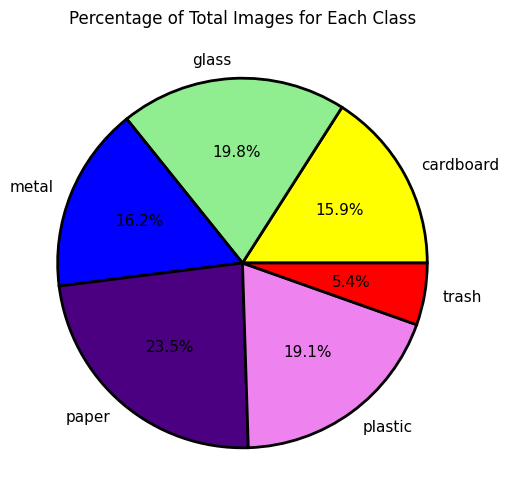

In [12]:
# Plot pie chart
textprops = {'fontsize':11 , }
wedgeprops = {'linewidth':2 , 'width':1,'edgecolor':'k'}

plt.figure(figsize=(6,6))
plt.pie(class_counts.values(),
        labels=class_counts.keys(),
        autopct='%1.1f%%',
        colors=['yellow','lightgreen','blue','indigo','violet','red'],
        textprops=textprops,
        wedgeprops=wedgeprops
        )
plt.title("Percentage of Total Images for Each Class")
plt.show()

## **Data Splitting**

In [14]:
dataset.column_names

['image', 'label']

In [13]:
# Initialize an empty list to store image information and their respective labels
data = []

# Loop through each item in the dataset and collect image paths and their labels
for item in dataset:
    # Extract the label
    label_num = item['label']
    label = label_mapping[label_num]

    # Append the image and its label to the data list
    data.append((item['image'], label))

# Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['image', 'label'])

In [15]:
# Display the first few entries of the DataFrame
print(pd.DataFrame(df.head()))

                                               image      label
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...  cardboard
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...  cardboard
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...  cardboard
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...  cardboard
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...  cardboard


In [28]:
print(df.info())  # Check data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2527 entries, 0 to 2526
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   2527 non-null   object
 1   label   2527 non-null   object
dtypes: object(2)
memory usage: 39.6+ KB
None


In [16]:
# Function to extract labels
def extract_labels(example):
    return {'labels': example['label']}

# Apply extraction to dataset
dataset = dataset.map(extract_labels, remove_columns=['label'])
#convert to list for use in stratify parameter

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Print the number of images in each set
print(f"Number of images in the training set: {len(train_df)}")
print(f"Number of images in the validation set: {len(val_df)}")

Map:   0%|          | 0/2527 [00:00<?, ? examples/s]

Number of images in the training set: 2021
Number of images in the validation set: 506


In [17]:
# 1. Class distribution in the entire dataset
overall_distribution = df['label'].value_counts(normalize=True) * 100

# 2. Class distribution in the training set
train_distribution = train_df['label'].value_counts(normalize=True) * 100

# 3. Class distribution in the validation set
val_distribution = val_df['label'].value_counts(normalize=True) * 100

print("Class distribution in the entire dataset:\n")
print(overall_distribution.round(2))
print('-'*40)

print("\nClass distribution in the training set:\n")
print(train_distribution.round(2))
print('-'*40)

print("\nClass distribution in the validation set:\n")
print(val_distribution.round(2))

Class distribution in the entire dataset:

label
paper        23.51
glass        19.83
plastic      19.07
metal        16.22
cardboard    15.95
trash         5.42
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the training set:

label
paper        23.50
glass        19.84
plastic      19.05
metal        16.23
cardboard    15.93
trash         5.44
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the validation set:

label
paper        23.52
glass        19.76
plastic      19.17
metal        16.21
cardboard    16.01
trash         5.34
Name: proportion, dtype: float64


## Data Augmentation & Rescaling

In [18]:
# Slight Augmentation settings for training
train_datagen = ImageDataGenerator(
    rescale=1./255,                     # Normalize pixel values to [0,1]
    rotation_range=45,                  # Randomly rotate the images by up to 45 degrees
    width_shift_range=0.15,             # Randomly shift images horizontally by up to 15% of the width
    height_shift_range=0.15,            # Randomly shift images vertically by up to 15% of the height
    zoom_range=0.15,                    # Randomly zoom in or out by up to 15%
    horizontal_flip=True,               # Randomly flip images horizontally
    vertical_flip=True,                 # Randomly flip images vertically
    shear_range=0.05,                   # Apply slight shear transformations
    brightness_range=[0.9, 1.1],        # Vary brightness between 90% to 110% of original
    channel_shift_range=10,             # Randomly shift channels (can change colors of images slightly but less aggressively)
    fill_mode='nearest'                 # Fill in missing pixels using the nearest filled value
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

## Generating Batches of Image

In [19]:
import os

output_dir = "image"
os.makedirs(output_dir, exist_ok=True)

# Save images and return string file paths
def save_image_and_get_path(row):
    img_path = os.path.join(output_dir, f"{row.name}.jpg")
    if isinstance(row["image"], str):  # Already a path
        return row["image"]
    elif hasattr(row["image"], "save"):  # Check if it's a PIL image
        row["image"].save(img_path)
        return img_path  # Return the string path
    else:
        return None  # Handle unexpected cases

# Apply function to create new 'filepath' column
train_df["filepath"] = train_df.apply(save_image_and_get_path, axis=1)
val_df["filepath"] = val_df.apply(save_image_and_get_path, axis=1)

# Drop rows where filepath is None (invalid images)
train_df = train_df.dropna(subset=["filepath"])
val_df = val_df.dropna(subset=["filepath"])

# Ensure all paths are strings
train_df["filepath"] = train_df["filepath"].astype(str)
val_df["filepath"] = val_df["filepath"].astype(str)

x_col="filepath"

print(train_df["filepath"].head())  # Should show valid file paths
print(type(train_df["filepath"].iloc[0]))  # Should be <class 'str'>

2395    image/2395.jpg
567      image/567.jpg
741      image/741.jpg
1720    image/1720.jpg
1066    image/1066.jpg
Name: filepath, dtype: object
<class 'str'>


In [20]:
# Using flow_from_dataframe to generate batches
# Generate training batches from the training dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                  # DataFrame containing training data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)


# Generate validation batches from the validation dataframe
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,                    # DataFrame containing validation data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                     # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)

Found 2021 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.


In [21]:
print(f"Number of batches in train_generator: {len(train_generator)}")
print(f"Number of batches in val_generator: {len(val_generator)}")

Number of batches in train_generator: 64
Number of batches in val_generator: 16


In [38]:
# Get number of batches per epoch
num_batches = len(train_generator)

# Get total number of augmented images per epoch
total_augmented_images = num_batches * train_generator.batch_size

print(f"Total augmented images per epoch: {total_augmented_images}")

Total augmented images per epoch: 2048


## Addressing Dataset Imbalances

In [22]:
# Extract class labels from the 'label' column of train_df
class_labels = train_df['label'].unique()
class_labels

array(['trash', 'glass', 'paper', 'metal', 'plastic', 'cardboard'],
      dtype=object)

In [23]:
# Compute class weights
weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=train_df['label'])
weights

array([3.06212121, 0.83998337, 0.70912281, 1.02693089, 0.87489177,
       1.04606625])

In [24]:
# Convert the computed weights to a dictionary for passing to model training
class_weights = dict(zip(train_generator.class_indices.values(), weights))
class_weights

{0: 3.062121212121212,
 1: 0.8399833748960931,
 2: 0.7091228070175438,
 3: 1.026930894308943,
 4: 0.8748917748917749,
 5: 1.0460662525879918}